## CartPole avec Policy Gradient REINFORCE 

L'objectif ici est d'implémenter un agent qui utilise la méthode Policy Gradient capable d'apprendre et de réussir dans l'environnement CartPole :

### CartPole : 
Cet environnement simple consiste à faire tenir en équilibre un baton dans un chariot.

Chaque pas de temps ou le baton tiens en équilibre rapporte 1 point de reward.

Chaque épisode débute avec le baton à 0° et se termine sous 3 conditions distinctes : 
- le baton s'incline de + de 15°
- le chariot sort de la piste
- le score des rewards cumulé arrive à 500

---

#### Import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

### Policy

Ce reseau de neuronne simple composé de 3 couches connectées prend en entrée l'état de l'environnement et en ressort la distribution des probabilités de chaque action afin d'optimiser le total des rewards

In [3]:
class Policy(nn.Module):
    """
    Réseau de neurones simple utilisé pour approximer la politique 
    dans la méthode de Policy Gradient.
    """
    def __init__(self, state_space_size:int, action_space_size:int):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_space_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_space_size)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)

---

### PolicyGradientAgent
Cette classe permet d'implementer notre agent qui évoluera dans l'environnement : 
Elle initialise la politique et les paramètres de l'agent.

In [4]:
class PolicyGradientAgent:
    def __init__(self, state_space_size:int, action_space_size:int):
        self.policy = Policy(state_space_size, action_space_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
        self.gamma = 0.99
        self.eps = self.eps = np.finfo(np.float32).eps.item()

        self.rewards = []
        self.log_probs = []

    def pick_action(self, state) -> int:
        """
        Choisit une action à partir de l'état donné.

        Args:
        - state (np.ndarray) : état actuel de l'environnement

        Returns:
        - action (int) : action selectionnée par l'agent
        """
        if type(state) == tuple:
            state = torch.from_numpy(state[0]).float().unsqueeze(0)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.log_probs.append(m.log_prob(action))
        return action.item()

    def play_episode(self, environment: gym.Env)-> float:
        """
        Joue un épisode complet de notre environnement

        Args:
        - environment (gym.Env) : environnement dans lequel l'agent évolue

        Returns:
        - episode_reward (float) : récompense totale pour l'épisode
        """
        state = environment.reset()
        done = False
        episode_reward = 0

        while not done:
            action = self.pick_action(state)
            state, reward, done, info, _ = environment.step(action)
            self.rewards.append(reward)
            episode_reward += reward
            if episode_reward >= 500:
                done = True
            
        return episode_reward

    def train_agent(self):
        """
        Entraîne l'agent sur les épisodes précédents
        """
        discounts = [self.gamma**i for i in range(len(self.rewards))]
        rewards = torch.tensor(self.rewards)
        discounts = torch.tensor(discounts)
        discounts = discounts.float().unsqueeze(1)
        rewards = rewards.float().unsqueeze(1)

        discounted_rewards = discounts * rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + self.eps)

        policy_loss = []
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)
        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.rewards = []
        self.log_probs = []


#### Explication de la fonction `train_agent()` :
- Dans un 1er temps, la fonction calcule les réductions de récompenses avec `gamma` (discounts).

- Cela permet d'apporter plus ou moins d'importances au récompenses futures et ainsi permettre à l'agent de privilégier des récompenses court termes impliquant une "résolution immédiate" plutôt que des récompenses long terme.

- On calcule ensuite la loss pour chaque action : `-log_prob * reward` puis la loss totale de l'épisode avec `.sum()`

- On met à jour les poids du réseau de neuronne avec la méthode de descente de gradient.

- Puis on remet à vide les array de `rewards` et `log_probs` pour l'épisode suivant



---

### Lancement des épisodes
Ici, on lance nos 1000 épisodes (chiffre arbitraire) afin d'entrainer notre agent.

On récupére l'historique des rewards afin de plot la progression finale.

La variable `count_score_max` fait office d'EarlyStopping, on stop l'entrainement dès lors qu'on à 10 scores de 500 d'affilée

In [5]:
env = gym.make('CartPole-v1')
agent = PolicyGradientAgent(state_space_size=4, action_space_size=2)

num_episodes = 1000
rewards_history = []
count_score_max = 0
i = 0
while i < num_episodes and count_score_max < 10:
    episode_reward = agent.play_episode(env)
    agent.train_agent()
    rewards_history.append(episode_reward)

    print('Episode {}: reward = {}'.format(i, episode_reward))
    if episode_reward == 500:
        count_score_max+=1
    else:
        count_score_max=0
    i+=1

env.close()

Episode 0: reward = 14.0
Episode 1: reward = 31.0
Episode 2: reward = 13.0
Episode 3: reward = 20.0
Episode 4: reward = 8.0
Episode 5: reward = 15.0
Episode 6: reward = 22.0
Episode 7: reward = 22.0
Episode 8: reward = 17.0
Episode 9: reward = 21.0
Episode 10: reward = 18.0
Episode 11: reward = 35.0
Episode 12: reward = 11.0
Episode 13: reward = 47.0
Episode 14: reward = 44.0
Episode 15: reward = 14.0
Episode 16: reward = 28.0
Episode 17: reward = 26.0
Episode 18: reward = 85.0
Episode 19: reward = 26.0
Episode 20: reward = 30.0
Episode 21: reward = 20.0
Episode 22: reward = 11.0
Episode 23: reward = 12.0
Episode 24: reward = 16.0
Episode 25: reward = 46.0
Episode 26: reward = 13.0
Episode 27: reward = 54.0
Episode 28: reward = 18.0
Episode 29: reward = 24.0
Episode 30: reward = 24.0
Episode 31: reward = 13.0
Episode 32: reward = 17.0
Episode 33: reward = 22.0
Episode 34: reward = 19.0
Episode 35: reward = 11.0
Episode 36: reward = 34.0
Episode 37: reward = 20.0
Episode 38: reward = 18

---

### Plot de la courbe de progression des rewards

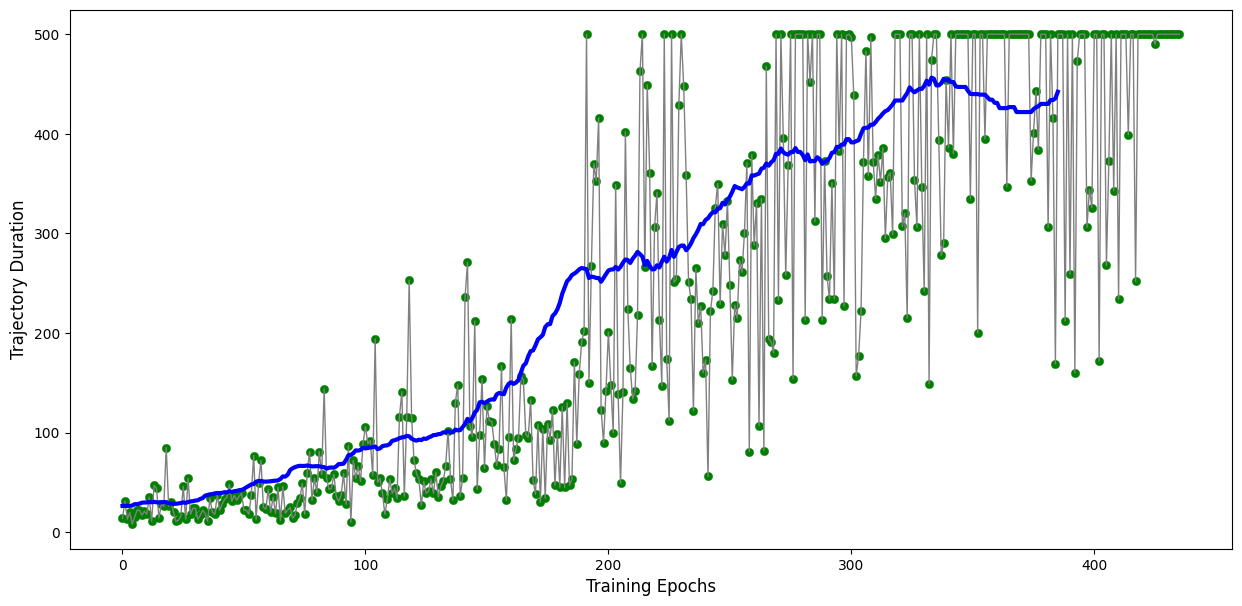

In [8]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_history)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

#### Test final sur un épisode avec le `render_mode=human`

In [9]:
env = gym.make('CartPole-v1', render_mode='human')

reward_episode = agent.play_episode(env)
print('Reward = {}'.format(reward_episode))
env.close()

Reward = 500.0


#### Conclusion

On peut voir que, pour cet entrainement, notre agent est capable d'arriver à ses 1er 500points vers les 200 épisodes, mais il lui faudra une bonne centaine d'épisodes suplémentaires pour y parvenir avec une certaine régularité.

Aussi, au cours des différentes sessions d'entrainements, j'ai pu remarquer que notre agent pouvait completement "désapprendre" et ainsi retourner à un reward moyen de 100 après avoir passer plusieurs centaines d'épisodes à tourner autour du 500, c'est pourquoi j'ai rajouté de l'EarlyStopping afin d'éviter ce problème.


